# Model-based estimated fisheries nutrition by EEZ - reported only

In [1]:
# Import python packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import pymc3 as pm
import theano as T
import theano.tensor as tt
import seaborn as sns
import scipy as sp
import pdb
import os as os

# Helper functions
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

match = lambda a, b: np.array([ b.index(x) if x in b else None for x in a ])
grep = lambda s, l: np.array([i for i in l if s in i])

# Function to standardize covariates
def stdize(x):
    return (x-np.mean(x))/(2*np.std(x))

def spanzero(pair):
    out = True
    if all(pair<0) or all(pair>0):
        out = False
    return out

## Import data sources

In [2]:
# Nutritional data
ndata = pd.read_excel('Nutrient_data.xlsx')
# Traits data
tdata = pd.read_csv('Traits_data.csv')
# Sea Around Us data
sdata = pd.read_csv('Reported_EEZ.csv')

In [3]:
len(sdata.EEZ.unique())

274

In [4]:
dfa = pd.get_dummies(tdata[['DemersPelag', 'EnvTemp',
       'DepthRangeDeep', 'trophic_level', 'Feeding_path', 'LMax',
       'BodyShapeI', 'K', 'tm', 'DemersPelagLevel', 'EnvTempLevel',
       'DepthRangeDeepLevel', 'trophic_levelLevel', 'Feeding_pathLevel',
       'LMaxLevel', 'BodyShapeILevel', 'KLevel', 'tmLevel']])
trait_corr = dfa.corr()
#trait_corr

In [5]:
trait_corr.to_csv('trait_correlations.csv')

In [6]:
## Get proportion of total catch per species per EEZ

# National total catch
tmp_nations,It = indexall(sdata.EEZ.values)
sdata['prop_catch'] = sdata.annual_tonnage.values/np.array([sum(sdata.annual_tonnage.values[sdata.EEZ.values==c]) for c in tmp_nations])[It]

In [7]:
# Add traits information to nutritional dataframe
indx = match(ndata.Species_from_search.unique(),list(tdata.species_traits_all.values))
rindx = match(ndata.Species_from_search,list(ndata.Species_from_search.unique()))

# Traits to port over
tmp = ['Class', 'Order', 'Family','Genus_1', 'DemersPelag',
       'EnvTemp', 'DepthRangeDeep', 'trophic_level', 'Feeding_path', 'LMax',
       'BodyShapeI', 'K', 'tm']
# Port over
for trait in tmp:
    ndata[trait] = tdata[trait].values[indx][rindx]

In [8]:
# Add traits information to sau dataframe
indx = match(sdata.species.unique(),list(tdata.species_traits_all.values))
rindx = match(sdata.species,list(sdata.species.unique()))

# Traits to port over
tmp = ['Class', 'Order', 'Family','Genus_1', 'DemersPelag',
       'EnvTemp', 'DepthRangeDeep', 'trophic_level', 'Feeding_path', 'LMax',
       'BodyShapeI', 'K', 'tm']
# Port over
for trait in tmp:
    sdata[trait] = tdata[trait].values[indx][rindx]

In [9]:
len(sdata.EEZ.unique())

274

In [10]:
# Remove SAU rows with -999
mdata = sdata.loc[sdata.K==-999,]
sdata = sdata.loc[sdata.K!=-999,]

In [11]:
# Check there's nothing missing
mdata

,EEZ,species,5yr_catch_tonnage,annual_tonnage,prop_catch,Class,Order,Family,Genus_1,DemersPelag,EnvTemp,DepthRangeDeep,trophic_level,Feeding_path,LMax,BodyShapeI,K,tm


In [12]:
len(sdata.EEZ.unique())

274

In [13]:
Nutrients = ['Protein', 'Zinc', 'Iron', 'Calcium', 'Omega3', 'Vitamin_A', 'Selenium']
Nkeys = ['Protein_Value_perc', 'Zn_Value', 'Fe_Value', 'Ca_Value', 'O3_Value', 'VitA_Value', 'Se_Value']
nnutrients = len(Nutrients)

## Import results

In [14]:
Protein = pd.read_csv('Protein_results.csv')
Zinc = pd.read_csv('Zinc_results.csv')
Iron = pd.read_csv('Iron_results.csv')
Calcium = pd.read_csv('Calcium_results.csv')
Omega3 = pd.read_csv('Omega-3_results.csv')
Vitamin_A = pd.read_csv('Vitamin_A_results.csv')
Selenium = pd.read_csv('Selenium_results.csv')

Results = [Protein, Zinc, Iron, Calcium, Omega3, Vitamin_A, Selenium]

In [15]:
varord = ['reef_assoc', 'benthopela', 'pelagic_ne',
       'pelagic_oc', 'subtropica', 'polar_deep', 'tropical', 'MaxDepth', 'TL',
       'Pelagic', 'LMax', 'short_deep', 'elongate', 'flat', 'K', 'tm', 'whole',
       'whole_part', 'dry', 'Expert', 'FAO']
varnames = ['Reef assoc.', 'Benthopelagic', 'Pelagic-neritic',
       'Pelagic-oceanic', 'Subtropical', 'Polar/deep', 'Tropical', 'Max depth', 'Trophic level',
       'Pelagic', 'Max length', 'Short-deep', 'Elongate', 'Flat', 'K', 'Maturity age', 'Whole',
       'Whole-noparts', 'Dry', 'Expert', 'FAO']
nvar = len(varnames)

# EEZ predictions

In [16]:
nrows = sdata.shape[0]
nrows

4604

In [17]:
# Specify nutrient
REZ = Protein

# Add empty columns to SAU data
xmu = np.empty(nrows)
xl95 = np.empty(nrows)
xl50 = np.empty(nrows)
xu50 = np.empty(nrows)
xu95 = np.empty(nrows)

for i in range(nrows):
    #print(i/nrows)
    # μ = β0+β1[Ih]+β2[Ic]+β3*MaxDepth+β4*TL+β5*Pelagic+β6*LMax+β7[Ib]+β8*K+β9*tm+β10[If]+β11[Ip]+β12[Is]
    tmp = sdata.iloc[i]
    # Expected nutrients
    Ex = REZ['Intercept'].values+REZ[tmp['DemersPelag']].values+REZ[tmp['EnvTemp']].values+REZ['MaxDepth'].values*np.log(tmp['DepthRangeDeep'])+REZ['TL'].values*tmp['trophic_level']+REZ['pelagic'].values*1*(tmp['Feeding_path']=='pelagic')+REZ['LMax'].values*np.log(tmp['LMax'])+REZ[tmp['BodyShapeI']].values+REZ['K'].values*tmp['K']+REZ['tm'].values*np.log(tmp['tm'])
    # Scaled to catch - g/100g to kg/yr = g/kg/yr
    #nut = ((np.exp(Ex)-1)*10)*np.log(tmp['kg_year']/1000+1)
    nut = ((np.exp(Ex)-1))
    
    # Add summary statistics to SAU data
    xmu[i] = max(np.median(nut),0)
    xl95[i] = max(np.percentile(nut,2.5),0)
    xl50[i] = max(np.percentile(nut,25),0)
    xu50[i] = max(np.percentile(nut,50),0)
    xu95[i] = max(np.percentile(nut,97.5),0)
    
sdata['Protein_mu'] = xmu*sdata.prop_catch.values
sdata['Protein_l95'] = xl95*sdata.prop_catch.values
sdata['Protein_l50'] = xl50*sdata.prop_catch.values
sdata['Protein_u50'] = xu50*sdata.prop_catch.values
sdata['Protein_u95'] = xu95*sdata.prop_catch.values

In [18]:
sdata.prop_catch.values

array([3.51890573e-09, 3.24572396e-03, 7.70531575e-03, ...,
       2.05913503e-02, 1.00055182e-02, 1.16047776e-01])

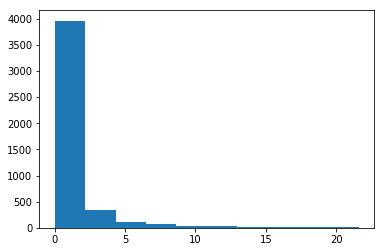

In [19]:
plt.hist(sdata['Protein_mu']);

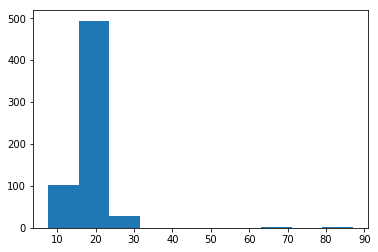

In [20]:
Y_ = ndata.Protein_Value_perc.values
indx = np.isnan(Y_)==False
Y = Y_[indx]
plt.hist(Y);

In [21]:
# Specify nutrient
REZ = Zinc

# Add empty columns to SAU data
xmu = np.empty(nrows)
xl95 = np.empty(nrows)
xl50 = np.empty(nrows)
xu50 = np.empty(nrows)
xu95 = np.empty(nrows)

for i in range(nrows):
    #print(i/nrows)
    # μ = β0+β1[Ih]+β2[Ic]+β3*MaxDepth+β4*TL+β5*Pelagic+β6*LMax+β7[Ib]+β8*K+β9*tm+β10[If]+β11[Ip]+β12[Is]
    tmp = sdata.iloc[i]
    # Expected nutrients
    Ex = REZ['Intercept'].values+REZ[tmp['DemersPelag']].values+REZ[tmp['EnvTemp']].values+REZ['MaxDepth'].values*np.log(tmp['DepthRangeDeep'])+REZ['TL'].values*tmp['trophic_level']+REZ['pelagic'].values*1*(tmp['Feeding_path']=='pelagic')+REZ['LMax'].values*np.log(tmp['LMax'])+REZ[tmp['BodyShapeI']].values+REZ['K'].values*tmp['K']+REZ['tm'].values*np.log(tmp['tm'])
    # Scaled to catch - g/100g to kg/yr = g/kg/yr
    #nut = ((np.exp(Ex)-1)*10)*np.log(tmp['kg_year']/1000+1)
    nut = np.exp(((np.exp(Ex))))-1
    
    # Add summary statistics to SAU data
    xmu[i] = max(np.median(nut),0)
    xl95[i] = max(np.percentile(nut,2.5),0)
    xl50[i] = max(np.percentile(nut,25),0)
    xu50[i] = max(np.percentile(nut,50),0)
    xu95[i] = max(np.percentile(nut,97.5),0)
    
sdata['Zinc_mu'] = xmu*sdata.prop_catch.values
sdata['Zinc_l95'] = xl95*sdata.prop_catch.values
sdata['Zinc_l50'] = xl50*sdata.prop_catch.values
sdata['Zinc_u50'] = xu50*sdata.prop_catch.values
sdata['Zinc_u95'] = xu95*sdata.prop_catch.values

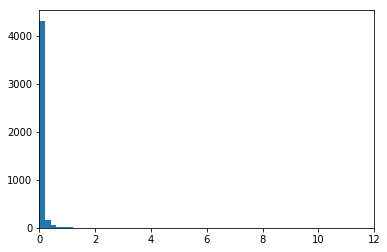

In [22]:
plt.hist(sdata['Zinc_mu'])
plt.xlim(0,12);

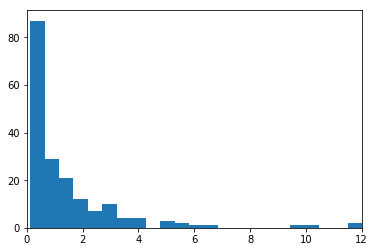

In [23]:
Y_ = ndata.Zn_Value.values
indx = np.isnan(Y_)==False
Y = Y_[indx]
plt.hist(Y,bins=50)
plt.xlim(0,12);

In [24]:
# Specify nutrient
REZ = Iron

# Add empty columns to SAU data
xmu = np.empty(nrows)
xl95 = np.empty(nrows)
xl50 = np.empty(nrows)
xu50 = np.empty(nrows)
xu95 = np.empty(nrows)

for i in range(nrows):
    #print(i/nrows)
    # μ = β0+β1[Ih]+β2[Ic]+β3*MaxDepth+β4*TL+β5*Pelagic+β6*LMax+β7[Ib]+β8*K+β9*tm+β10[If]+β11[Ip]+β12[Is]
    tmp = sdata.iloc[i]
    # Expected nutrients
    Ex = REZ['Intercept'].values+REZ[tmp['DemersPelag']].values+REZ[tmp['EnvTemp']].values+REZ['MaxDepth'].values*np.log(tmp['DepthRangeDeep'])+REZ['TL'].values*tmp['trophic_level']+REZ['pelagic'].values*1*(tmp['Feeding_path']=='pelagic')+REZ['LMax'].values*np.log(tmp['LMax'])+REZ[tmp['BodyShapeI']].values+REZ['K'].values*tmp['K']+REZ['tm'].values*np.log(tmp['tm'])
    # Scaled to catch - g/100g to kg/yr = g/kg/yr
    #nut = ((np.exp(Ex)-1)*10)*np.log(tmp['kg_year']/1000+1)
    nut = np.exp((np.exp(Ex)))-1
    
    # Add summary statistics to SAU data
    xmu[i] = max(np.median(nut),0)
    xl95[i] = max(np.percentile(nut,2.5),0)
    xl50[i] = max(np.percentile(nut,25),0)
    xu50[i] = max(np.percentile(nut,50),0)
    xu95[i] = max(np.percentile(nut,97.5),0)
    
sdata['Iron_mu'] = xmu*sdata.prop_catch.values
sdata['Iron_l95'] = xl95*sdata.prop_catch.values
sdata['Iron_l50'] = xl50*sdata.prop_catch.values
sdata['Iron_u50'] = xu50*sdata.prop_catch.values
sdata['Iron_u95'] = xu95*sdata.prop_catch.values

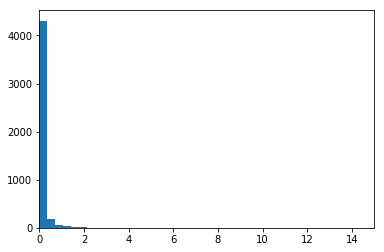

In [25]:
plt.hist(sdata['Iron_mu'],bins=10)
plt.xlim(0,15);

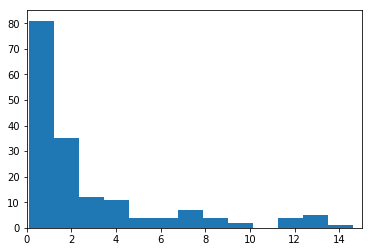

In [26]:
Y_ = ndata.Fe_Value.values
indx = np.isnan(Y_)==False
Y = Y_[indx]
plt.hist(Y,bins=100)
plt.xlim(0,15);

In [27]:
# Specify nutrient
REZ = Calcium

# Add empty columns to SAU data
xmu = np.empty(nrows)
xl95 = np.empty(nrows)
xl50 = np.empty(nrows)
xu50 = np.empty(nrows)
xu95 = np.empty(nrows)

for i in range(nrows):
    #print(i/nrows)
    # μ = β0+β1[Ih]+β2[Ic]+β3*MaxDepth+β4*TL+β5*Pelagic+β6*LMax+β7[Ib]+β8*K+β9*tm+β10[If]+β11[Ip]+β12[Is]
    tmp = sdata.iloc[i]
    # Expected nutrients
    Ex = REZ['Intercept'].values+REZ[tmp['DemersPelag']].values+REZ[tmp['EnvTemp']].values+REZ['MaxDepth'].values*np.log(tmp['DepthRangeDeep'])+REZ['TL'].values*tmp['trophic_level']+REZ['pelagic'].values*1*(tmp['Feeding_path']=='pelagic')+REZ['LMax'].values*np.log(tmp['LMax'])+REZ[tmp['BodyShapeI']].values+REZ['K'].values*tmp['K']+REZ['tm'].values*np.log(tmp['tm'])
    # Scaled to catch - g/100g to kg/yr = g/kg/yr
    #nut = ((np.exp(Ex)-1)*10)*np.log(tmp['kg_year']/1000+1)
    nut = ((np.exp(Ex)-1))
    
    # Add summary statistics to SAU data
    xmu[i] = max(np.median(nut),0)
    xl95[i] = max(np.percentile(nut,2.5),0)
    xl50[i] = max(np.percentile(nut,25),0)
    xu50[i] = max(np.percentile(nut,50),0)
    xu95[i] = max(np.percentile(nut,97.5),0)
    
sdata['Calcium_mu'] = xmu*sdata.prop_catch.values
sdata['Calcium_l95'] = xl95*sdata.prop_catch.values
sdata['Calcium_l50'] = xl50*sdata.prop_catch.values
sdata['Calcium_u50'] = xu50*sdata.prop_catch.values
sdata['Calcium_u95'] = xu95*sdata.prop_catch.values

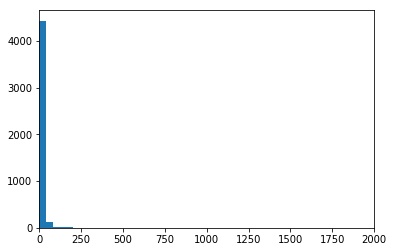

In [28]:
plt.hist(sdata['Calcium_mu'])
plt.xlim(0,2000);

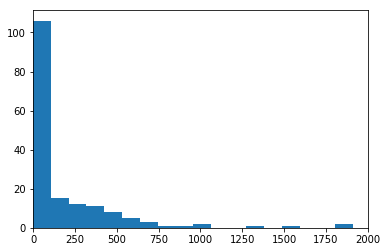

In [29]:
Y_ = ndata.Ca_Value.values
indx = np.isnan(Y_)==False
Y = Y_[indx]
plt.hist(Y,bins=50)
plt.xlim(0,2000);

In [30]:
# Specify nutrient
REZ = Omega3

# Add empty columns to SAU data
xmu = np.empty(nrows)
xl95 = np.empty(nrows)
xl50 = np.empty(nrows)
xu50 = np.empty(nrows)
xu95 = np.empty(nrows)

for i in range(nrows):
    #print(i/nrows)
    # μ = β0+β1[Ih]+β2[Ic]+β3*MaxDepth+β4*TL+β5*Pelagic+β6*LMax+β7[Ib]+β8*K+β9*tm+β10[If]+β11[Ip]+β12[Is]
    tmp = sdata.iloc[i]
    # Expected nutrients
    Ex = REZ['Intercept'].values+REZ[tmp['DemersPelag']].values+REZ[tmp['EnvTemp']].values+REZ['MaxDepth'].values*np.log(tmp['DepthRangeDeep'])+REZ['TL'].values*tmp['trophic_level']+REZ['pelagic'].values*1*(tmp['Feeding_path']=='pelagic')+REZ['LMax'].values*np.log(tmp['LMax'])+REZ[tmp['BodyShapeI']].values+REZ['K'].values*tmp['K']+REZ['tm'].values*np.log(tmp['tm'])
    # Scaled to catch - g/100g to kg/yr = g/kg/yr
    #nut = ((np.exp(Ex)-1)*10)*np.log(tmp['kg_year']/1000+1)
    nut = ((np.exp(Ex)-1))
    
    # Add summary statistics to SAU data
    xmu[i] = max(np.median(nut),0)
    xl95[i] = max(np.percentile(nut,2.5),0)
    xl50[i] = max(np.percentile(nut,25),0)
    xu50[i] = max(np.percentile(nut,50),0)
    xu95[i] = max(np.percentile(nut,97.5),0)
    
sdata['Omega3_mu'] = xmu*sdata.prop_catch.values
sdata['Omega3_l95'] = xl95*sdata.prop_catch.values
sdata['Omega3_l50'] = xl50*sdata.prop_catch.values
sdata['Omega3_u50'] = xu50*sdata.prop_catch.values
sdata['Omega3_u95'] = xu95*sdata.prop_catch.values

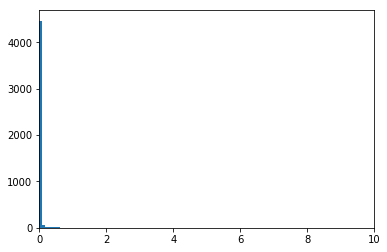

In [31]:
plt.hist(sdata['Omega3_mu'])
plt.xlim(0,10);

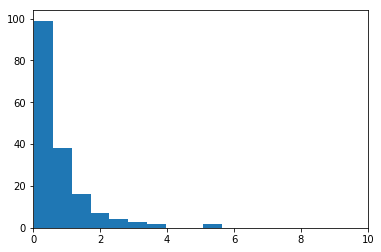

In [32]:
Y_ = ndata.O3_Value.values
indx = np.isnan(Y_)==False
Y = Y_[indx]
plt.hist(Y,bins=100)
plt.xlim(0,10);

In [33]:
# Specify nutrient
REZ = Vitamin_A

# Add empty columns to SAU data
xmu = np.empty(nrows)
xl95 = np.empty(nrows)
xl50 = np.empty(nrows)
xu50 = np.empty(nrows)
xu95 = np.empty(nrows)

for i in range(nrows):
    #print(i/nrows)
    # μ = β0+β1[Ih]+β2[Ic]+β3*MaxDepth+β4*TL+β5*Pelagic+β6*LMax+β7[Ib]+β8*K+β9*tm+β10[If]+β11[Ip]+β12[Is]
    tmp = sdata.iloc[i]
    # Expected nutrients
    Ex = REZ['Intercept'].values+REZ[tmp['DemersPelag']].values+REZ[tmp['EnvTemp']].values+REZ['MaxDepth'].values*np.log(tmp['DepthRangeDeep'])+REZ['TL'].values*tmp['trophic_level']+REZ['pelagic'].values*1*(tmp['Feeding_path']=='pelagic')+REZ['LMax'].values*np.log(tmp['LMax'])+REZ[tmp['BodyShapeI']].values+REZ['K'].values*tmp['K']+REZ['tm'].values*np.log(tmp['tm'])
    # Scaled to catch - g/100g to kg/yr = g/kg/yr
    #nut = ((np.exp(Ex)-1)*10)*np.log(tmp['kg_year']/1000+1)
    nut = ((np.exp(Ex)-1))
    
    # Add summary statistics to SAU data
    xmu[i] = max(np.median(nut),0)
    xl95[i] = max(np.percentile(nut,2.5),0)
    xl50[i] = max(np.percentile(nut,25),0)
    xu50[i] = max(np.percentile(nut,50),0)
    xu95[i] = max(np.percentile(nut,97.5),0)
    
sdata['Vitamin_A_mu'] = xmu*sdata.prop_catch.values
sdata['Vitamin_A_l95'] = xl95*sdata.prop_catch.values
sdata['Vitamin_A_l50'] = xl50*sdata.prop_catch.values
sdata['Vitamin_A_u50'] = xu50*sdata.prop_catch.values
sdata['Vitamin_A_u95'] = xu95*sdata.prop_catch.values

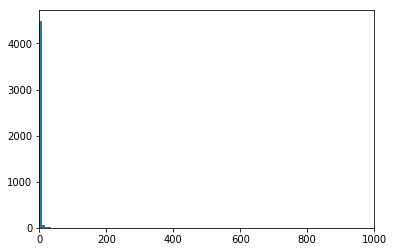

In [34]:
plt.hist(sdata['Vitamin_A_mu'])
plt.xlim(0,1000);

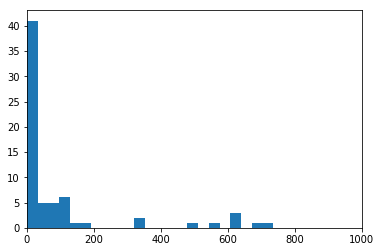

In [35]:
Y_ = ndata.VitA_Value.values
indx = np.isnan(Y_)==False
Y = Y_[indx]
plt.hist(Y,bins=100)
plt.xlim(0,1000);

In [36]:
# Specify nutrient
REZ = Selenium

# Add empty columns to SAU data
xmu = np.empty(nrows)
xl95 = np.empty(nrows)
xl50 = np.empty(nrows)
xu50 = np.empty(nrows)
xu95 = np.empty(nrows)

for i in range(nrows):
    #print(i/nrows)
    # μ = β0+β1[Ih]+β2[Ic]+β3*MaxDepth+β4*TL+β5*Pelagic+β6*LMax+β7[Ib]+β8*K+β9*tm+β10[If]+β11[Ip]+β12[Is]
    tmp = sdata.iloc[i]
    # Expected nutrients
    Ex = REZ['Intercept'].values+REZ[tmp['DemersPelag']].values+REZ[tmp['EnvTemp']].values+REZ['MaxDepth'].values*np.log(tmp['DepthRangeDeep'])+REZ['TL'].values*tmp['trophic_level']+REZ['pelagic'].values*1*(tmp['Feeding_path']=='pelagic')+REZ['LMax'].values*np.log(tmp['LMax'])+REZ[tmp['BodyShapeI']].values+REZ['K'].values*tmp['K']+REZ['tm'].values*np.log(tmp['tm'])
    # Scaled to catch - g/100g to kg/yr = g/kg/yr
    #nut = ((np.exp(Ex)-1)*10)*np.log(tmp['kg_year']/1000+1)
    nut = ((np.exp(Ex)-1))
    
    # Add summary statistics to SAU data
    xmu[i] = max(np.median(nut),0)
    xl95[i] = max(np.percentile(nut,2.5),0)
    xl50[i] = max(np.percentile(nut,25),0)
    xu50[i] = max(np.percentile(nut,50),0)
    xu95[i] = max(np.percentile(nut,97.5),0)
    
sdata['Selenium_mu'] = xmu*sdata.prop_catch.values
sdata['Selenium_l95'] = xl95*sdata.prop_catch.values
sdata['Selenium_l50'] = xl50*sdata.prop_catch.values
sdata['Selenium_u50'] = xu50*sdata.prop_catch.values
sdata['Selenium_u95'] = xu95*sdata.prop_catch.values

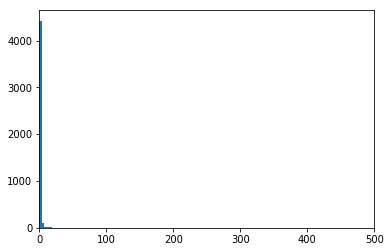

In [37]:
plt.hist(sdata['Selenium_mu'])
plt.xlim(0,500);

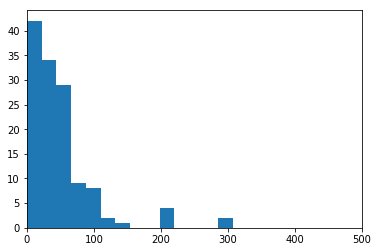

In [38]:
Y_ = ndata.Se_Value.values
indx = np.isnan(Y_)==False
Y = Y_[indx]
plt.hist(Y,bins=100)
plt.xlim(0,500);

In [39]:
out = sdata.groupby(['EEZ'])[["Protein_mu", "Zinc_mu", "Iron_mu", "Calcium_mu","Omega3_mu","Vitamin_A_mu","Selenium_mu"]].sum()

In [40]:
len(sdata.EEZ.unique())

274

In [41]:
# ADD missing EEZs back in
missing_eez = ['American_Samoa', 'Canada_(Arctic)','Cocos_(Keeling)_Isl_(Australia)', 'Russia_(Kara_Sea)', 'Russia_(Laptev_to_Chukchi_Sea)', 'USA_(Alaska_Arctic)']
nmissing = len(missing_eez)

maxi = out.shape[0]

for i in range(nmissing):
    out.loc[maxi+i] = 0

as_list = out.index.tolist()
as_list[-nmissing:] = missing_eez
out.index = as_list


In [42]:
out.index.name = 'EEZ'

In [43]:
# Sort by EEZ name
out = out.sort_values(['EEZ'],ascending=True)

In [44]:
out.to_csv("SAU_nutrient_projections_by_EEZ_reported.csv")

In [45]:
out.head()

,Protein_mu,Zinc_mu,Iron_mu,Calcium_mu,Omega3_mu,Vitamin_A_mu,Selenium_mu
EEZ,,,,,,,
Albania,20.237088,0.989376,1.977075,135.035620,0.354614,26.828790,11.728267
Algeria,19.858117,1.368307,2.447297,149.157704,0.331769,32.877411,11.780553
American_Samoa,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Andaman_&_Nicobar_Isl_(India),20.966075,1.234781,2.518956,41.426187,0.043227,12.719542,6.689949
Angola,19.307061,1.814234,2.469531,120.355042,0.213628,36.352289,7.188646
